In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader, IterableDataset, Dataset, Subset
from tqdm import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt
import random

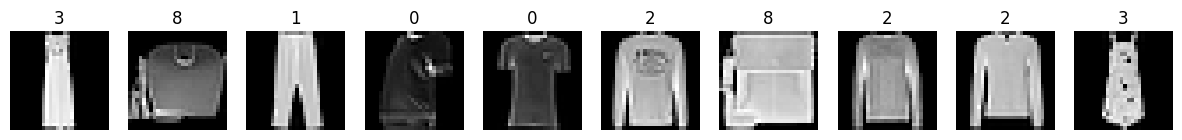

In [2]:
# load mnist dataset
def load_mnist(batch_size=64, train=True):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    trainset = datasets.FashionMNIST(root='./data', train=train, download=True, transform=transform)
    testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = load_mnist()
# display some images
def display_images(loader):
    import matplotlib.pyplot as plt
    for images, labels in loader:
        fig, ax = plt.subplots(1, 10, figsize=(15, 2))
        for i in range(10):
            ax[i].imshow(images[i].squeeze(), cmap='gray')
            ax[i].set_title(labels[i].item())
            ax[i].axis('off')
        plt.show()
        break
display_images(train_loader)

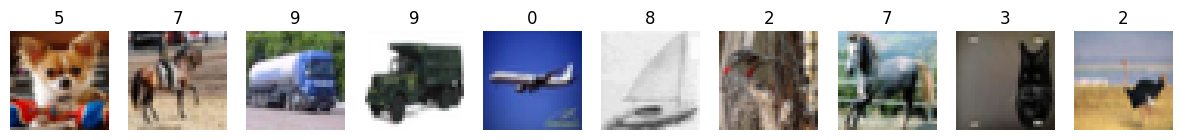

In [3]:
# load cifar10
def load_cifar10(batch_size=128, train=True):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    trainset = datasets.CIFAR10(root='./data', train=train, download=True, transform=transform)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader
train_loader_cifar, test_loader_cifar = load_cifar10()
# display some images for CIFAR10
def display_images_cifar(loader):
    import matplotlib.pyplot as plt
    for images, labels in loader:
        fig, ax = plt.subplots(1, 10, figsize=(15, 2))
        for i in range(10):
            ax[i].imshow(images[i].permute(1, 2, 0) / 2 + 0.5)  # unnormalize
            ax[i].set_title(labels[i].item())
            ax[i].axis('off')
        plt.show()
        break
display_images_cifar(train_loader_cifar)

In [ ]:
# load ImageNet-1K
data_dir = '/nethome/zwang910/file_storage/datasets/ImageNet'
# ———— Transforms ————
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std =[0.229, 0.224, 0.225])

train_tf = transforms.Compose([
    # transforms.RandomResizedCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])
# ———— Use torchvision.datasets.ImageNet ————
# NOTE: insists that `train/` and `val/` are organized into class subfolders.
train_dataset = datasets.ImageNet(root=data_dir, split='train', transform=train_tf)
val_dataset   = datasets.ImageNet(root=data_dir, split='val',   transform=val_tf)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True,
                          num_workers=8, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=256, shuffle=False,
                          num_workers=8, pin_memory=True)

In [ ]:
class TargetRemappedSubset(Dataset):
    """
    Wraps a Subset and remaps its targets via a given dict.
    """
    def __init__(self, subset: Subset, class_map: dict):
        self.subset    = subset
        self.class_map = class_map

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, orig_t = self.subset[idx]
        new_t = self.class_map[orig_t]
        return img, new_t


def make_random_imagenet_subset(
    dataset,
    num_classes: int = 10,
    images_per_class: int = 10000,
    seed: int = 101
):
    """
    Returns:
      remapped_subset: a Dataset of size num_classes*images_per_class
                        whose targets run 0 .. num_classes-1
      selected_classes: list of original class-indices (len=num_classes)
    """
    random.seed(seed)

    # build mapping: original class_idx -> list of sample-indices
    class_to_indices = {}
    for idx, (_, cls) in enumerate(dataset.samples):
        class_to_indices.setdefault(cls, []).append(idx)

    # choose classes
    all_classes = list(class_to_indices.keys())
    selected_classes = random.sample(all_classes, num_classes)

    # make a mapping from original -> new index
    class_map = {orig: new for new, orig in enumerate(selected_classes)}

    # sample indices (with replacement if needed)
    subset_inds = []
    for orig in selected_classes:
        inds = class_to_indices[orig]
        if len(inds) >= images_per_class:
            chosen = random.sample(inds, images_per_class)
        else:
            chosen = inds[:] + random.choices(inds, k=images_per_class - len(inds))
        subset_inds.extend(chosen)

    random.shuffle(subset_inds)

    base_subset = Subset(dataset, subset_inds)
    remapped   = TargetRemappedSubset(base_subset, class_map)
    return remapped, selected_classes

# 1) Make your 10-class × 10 000-images subset
train_subset, classes = make_random_imagenet_subset(
    train_dataset,
    num_classes=10,
    images_per_class=1000,
    seed=5454
)
print("Picked classes:", classes)

# 2) Wrap in a DataLoader exactly like your full dataset
train_loader_im1k = DataLoader(
    train_subset,
    batch_size=256,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)

Picked classes: [161, 907, 404, 275, 784, 646, 885, 479, 505, 0]


/tmp/ipykernel_2678530/64379420.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[i].imshow(images[i].permute(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07450981116294864..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9803921356201173].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.7418136649970393e-09..1.0000000076293944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with

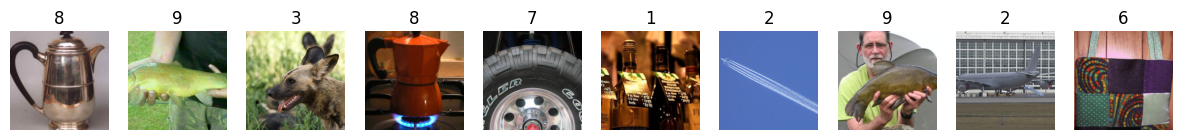

In [ ]:
# display some images for ImageNet
def display_images_imagenet(loader):
    import matplotlib.pyplot as plt
    for images, labels in loader:
        fig, ax = plt.subplots(1, 10, figsize=(15, 2))
        for i in range(10):
            ax[i].imshow(images[i].permute(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
            ax[i].set_title(labels[i].item())
            ax[i].axis('off')
        plt.show()
        break
display_images_imagenet(train_loader_im1k)

In [47]:
class TaxonConv(nn.Module):  
    def __init__(self, in_channels=1, kernel_size=7, n_layers=3, temperature=1.0):
        super(TaxonConv, self).__init__()
        self.in_channels = in_channels
        self.temperature = temperature
        self.n_layers = n_layers

        # create a conv for each depth i=1..n_layers, out_channels=2**i
        self.convs = nn.ModuleList([
            nn.Conv2d(
                in_channels=self.in_channels,
                out_channels=(1 << i),  # 2**(i+1) for i starting at 0
                kernel_size=kernel_size,
                stride=1,
                padding=int(kernel_size // 2),  # to keep the same spatial dimensions
                # bias=False
            )
            for i in range(self.n_layers)
        ])

    
    def stable_sigmoid(self, x: torch.Tensor) -> torch.Tensor:
        """
        Numerically stable sigmoid:
            sigmoid(x) = 1 / (1 + exp(-x))
        but computed piecewise to avoid overflow.
        """
        # For x >= 0:  sigmoid(x) = 1 / (1 + exp(-x))
        # For x <  0:  sigmoid(x) = exp(x) / (1 + exp(x))
        pos = (x >= 0)
        neg = ~pos

        out = torch.empty_like(x)
        # safe for large positive x
        out[pos] = 1.0 / (1.0 + torch.exp(-x[pos]))
        # safe for large negative x
        exp_x = torch.exp(x[neg])
        out[neg] = exp_x / (1.0 + exp_x)

        return out

    def forward(self, x):
        outputs = []
        prev = None
        dkl = 0.0

        for idx, conv in enumerate(self.convs):
            # compute log-likelihood
            ll = conv(x) / self.temperature
            ll = F.sigmoid(ll) # apply sigmoid to get probabilities in [0, 1]
            # clamp to avoid numerical issues
            ll = torch.clamp(ll, 1e-6, 1 - 1e-6)
            # print ll range
            # print("Log-likelihood range for layer {}: [{}, {}]".format(idx, ll.min().item(), ll.max().item()))
            if not torch.all((0 <= ll) & (ll <= 1)):
                print("Log-likelihood for layer {} is out of range [0, 1]".format(idx))
                print("Log-likelihood for layer {} at pixel (0,0): {}".format(idx, ll[0, :, 0, 0]))
                raise ValueError("Log-likelihood out of range [0, 1].")
            ll = torch.stack([ll, 1 - ll], dim=2).flatten(1, 2)  # shape (batch, channels, height, width)
            # check is ll is in [0, 1]
            logp = ll.log()  # convert to log-probabilities
            # check any nans in logp
            if torch.isnan(logp).any():
                print("Log-probabilities for layer {} contain NaNs".format(idx))
                print("Log-probabilities for layer {} at pixel (0,0): {}".format(idx, logp[0, :, 0, 0]))
                raise ValueError("Log-probabilities contain NaNs.")
            # logp = logp.view(logp.shape[0], -1, logp.shape[3], logp.shape[4])  # flatten the 2 channels
            # group every 2 channels together
            # ll = ll.view(ll.shape[0], -1, 2, ll.shape[2], ll.shape[3])  # shape (batch, channels//2, 2, height, width)
            # logp = ll - torch.logsumexp(ll, dim=2, keepdim=True) # shape (batch, channels//2, height, width)
            # logp = logp.view(logp.shape[0], -1, logp.shape[3], logp.shape[4])  # flatten the 2 channels
            # print first 10 pixels of the log-probabilities
            # print("Log-probabilities for layer {}: {}".format(idx, logp.view(-1)[:10]))
            # exp it to get probabilities for the first pixel in each channel

            # if not root, add the parent log-probs,
            # repeating them to match the 2× channel expansion
            if idx == 0:
                out = logp
            else:
                out = logp + prev.repeat_interleave(2, dim=1)
                # check if each pixel sums to 1 across channels
                if not torch.allclose(torch.exp(out).sum(dim=1), torch.ones_like(out[:, 0, :, :]), atol=1e-6):
                    print("Output probabilities do not sum to 1 across channels for layer {}".format(idx))
                    print("Probabilities for layer {} at pixel (0,0): {}".format(idx, torch.exp(out[0, :, 0, 0])))
                    raise ValueError("Output probabilities do not sum to 1 across channels.")
            # print("Probabilities for layer {} at pixel (0,0): {}".format(idx, torch.exp(out[0, :, 0, 0])))

            # check if the outputs at pixel 0,0 sums to 1 across channels
            # print("Output for layer {} at pixel (0,0): {}".format(idx, torch.exp(out[0, :, 0, 0]).sum().item()))

            out_expected = torch.full_like(out, 0.5 / (2**idx), device=out.device)
            # print("Probabilities for out_expected at layer {} at pixel (0,0): {}".format(idx, out_expected[0, :, 0, 0]))

            # compute DKL between out (in log space) and expected (in probability space)
            # print(out.shape, out_expected.shape)
            dkl_raw = F.kl_div(
                input=out,
                target=out_expected,
                reduction='none',
                log_target=False
            )
            dkl += dkl_raw.sum(dim=1).mean() # dkl for channels, averaged over batch and pixels
            # print("DKL for layer {}: {}".format(idx, dkl.item()))

            outputs.append(out)
            prev = out

        # concatenate all depths: channels = 2 + 4 + 8 + … + 2**n_layers
        return torch.cat(outputs, dim=1), dkl

In [41]:
class ThreeLayerTaxonCNN(nn.Module):
    def __init__(self, in_channels=1, image_size=32, temperature=1.0):
        super(ThreeLayerTaxonCNN, self).__init__()
        self.image_size = image_size
        self.in_channels = in_channels
        self.temperature = temperature
        self.taxon_conv1 = TaxonConv(in_channels=self.in_channels, n_layers=3, temperature=self.temperature) # 14 channels
        self.taxon_conv2 = TaxonConv(in_channels=14, n_layers=4, temperature=self.temperature) # 30 channels
        self.taxon_conv3 = TaxonConv(in_channels=30, n_layers=5, temperature=self.temperature) # 62 channels

        self.fc = nn.Linear(62 * 224 * 224, 10)  # 62 channels, each 4x4 after pooling

    def _squash(self, x, eps=1e-5):
        # first, normalize the input
        # then squash it to the range [-1, 1]
        # x: (B, C, H, W)
        m = x.mean(dim=[0,2,3], keepdim=True)
        s = x.std(dim=[0,2,3], keepdim=True) + eps
        return torch.tanh((x - m)/s)      
    
    def forward(self, x):
        # print(f"Before first conv: {x.min().item()} {x.max().item()}")  # Debugging line
        x = self.taxon_conv1(x) # shape (batch_size, 14, 32, 32)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self._squash(x)  # squash to range [-1, 1]
        # check range of x
        # print(f"After first conv: {x.min().item()} {x.max().item()}")  # Debugging line
        
        x = self.taxon_conv2(x) # shape (batch_size, 30, 16, 16)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        # print(f"After second pooling: {x.min().item()} {x.max().item()}")  # Debugging line
        x = self._squash(x)  # squash to range [-1, 1]
        # check range of x
        # print(f"After second conv: {x.min().item()} {x.max().item()}")

        x = self.taxon_conv3(x) # shape (batch_size, 62, 8, 8)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self._squash(x)  # squash to range [-1, 1]

        x = x.view(x.size(0), -1)  # flatten the output
        x = self.fc(x)
        return x

In [60]:
class OneLayerTaxonCNN(nn.Module):
    def __init__(self, in_channels=1, image_size=32, temperature=1.0):
        super(OneLayerTaxonCNN, self).__init__()
        self.image_size = image_size
        self.in_channels = in_channels
        self.temperature = temperature
        self.taxon_conv1 = TaxonConv(in_channels=self.in_channels, n_layers=4, temperature=self.temperature) # 30 channels
        self.taxon_conv2 = TaxonConv(in_channels=30, kernel_size=3, n_layers=5, temperature=self.temperature) # 30 channels

        # self.taxon_conv2 = TaxonConv(in_channels=14, n_layers=4, temperature=self.temperature) # 30 channels
        # self.taxon_conv3 = TaxonConv(in_channels=30, n_layers=5, temperature=self.temperature) # 62 channels

        self.fc = nn.Linear(62 * 8 * 8, 10)  # 62 channels, each 4x4 after pooling

    def _squash(self, x, eps=1e-5):
        # first, normalize the input
        # then squash it to the range [-1, 1]
        # x: (B, C, H, W)
        m = x.mean(dim=[0,2,3], keepdim=True)
        s = x.std(dim=[0,2,3], keepdim=True) + eps
        return torch.tanh((x - m)/s)      
    
    def forward(self, x):
        # print(f"Before first conv: {x.min().item()} {x.max().item()}")  # Debugging line
        x, dkl = self.taxon_conv1(x) # shape (batch_size, 14, 32, 32)
        x = self._squash(x)  # squash to range [-1, 1]
        x = F.relu(x)  # apply ReLU activation
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x, dkl2 = self.taxon_conv2(x)
        x = self._squash(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = x.view(x.size(0), -1)  # flatten the output
        x = self.fc(x)
        return x, dkl+dkl2

In [61]:
# train on MNIST, log predictions on test set and loss. Also plot them. Train for 5 epochs.
def train_model(model, train_loader, test_loader, epochs=1, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, dkl = model(images)
            # print(f"Output shape: {outputs.shape}, Labels shape: {labels.shape}")
            loss = criterion(outputs, labels)
            loss += 100*dkl  # add DKL to the loss
            # print(f"Loss: {loss.item():.4f}, DKL: {dkl.item():.4f}")

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # print(f"Batch Loss: {loss.item():.4f}")
            # break
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
        # print(f"Loss: {loss.item():.4f}, DKL: {dkl.item():.4f}")

        # # Evaluate on test set
        # model.eval()
        # correct = 0
        # total = 0
        # with torch.no_grad():
        #     for images, labels in test_loader:
        #         images, labels = images.to(device), labels.to(device)
        #         outputs = model(images)
        #         _, predicted = torch.max(outputs.data, 1)
        #         total += labels.size(0)
        #         correct += (predicted == labels).sum().item()

        # print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Initialize and train the model
# model = ThreeLayerTaxonCNN(in_channels=3, temperature=1.0)
model = OneLayerTaxonCNN(in_channels=3, temperature=0.5)

train_model(model, train_loader_cifar, train_loader_cifar, epochs=10, lr=0.001)


Epoch 1/10: 100%|██████████| 391/391 [00:15<00:00, 26.02it/s]


Epoch 1, Loss: 6.850536328142561


Epoch 2/10: 100%|██████████| 391/391 [00:14<00:00, 26.22it/s]


Epoch 2, Loss: 2.5078146963778054


Epoch 3/10: 100%|██████████| 391/391 [00:14<00:00, 26.12it/s]


Epoch 3, Loss: 2.254847594844106


Epoch 4/10: 100%|██████████| 391/391 [00:14<00:00, 26.29it/s]


Epoch 4, Loss: 2.0802449192232486


Epoch 5/10: 100%|██████████| 391/391 [00:14<00:00, 27.85it/s]


Epoch 5, Loss: 2.05483757717835


Epoch 6/10: 100%|██████████| 391/391 [00:14<00:00, 26.15it/s]


Epoch 6, Loss: 2.016558328552929


Epoch 7/10: 100%|██████████| 391/391 [00:14<00:00, 27.22it/s]


Epoch 7, Loss: 1.9885391073153758


Epoch 8/10: 100%|██████████| 391/391 [00:14<00:00, 27.17it/s]


Epoch 8, Loss: 1.9307212052137956


Epoch 9/10: 100%|██████████| 391/391 [00:14<00:00, 26.42it/s]


Epoch 9, Loss: 1.936899422684594


Epoch 10/10: 100%|██████████| 391/391 [00:14<00:00, 27.61it/s]

Epoch 10, Loss: 1.9266564638718315


In [ ]:
# # Save the model
torch.save(model.state_dict(), 'taxon_cnn-im1k-49-new.pth')

In [ ]:
# load the model
model = OneLayerTaxonCNN(in_channels=3, temperature=0.5)
model.load_state_dict(torch.load('taxon_cnn-im1k-49-new.pth'))

<All keys matched successfully>

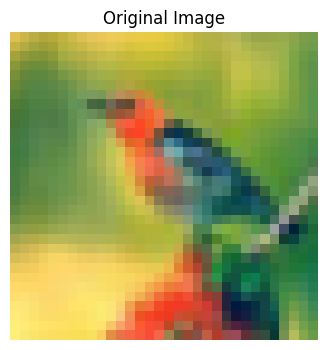

Probabilities for layer 1 at pixel (0,0): tensor([0.5041, 0.4959], device='cuda:0', grad_fn=<ExpBackward0>)


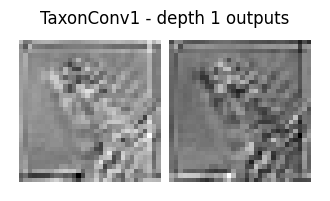

Probabilities for layer 2 at pixel (0,0): tensor([0.2517, 0.2523, 0.2449, 0.2510], device='cuda:0',
       grad_fn=<ExpBackward0>)


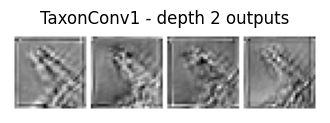

Probabilities for layer 3 at pixel (0,0): tensor([0.1296, 0.1221, 0.1276, 0.1247, 0.1216, 0.1233, 0.1275, 0.1235],
       device='cuda:0', grad_fn=<ExpBackward0>)


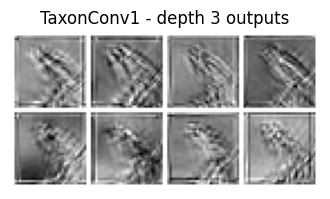

Probabilities for layer 4 at pixel (0,0): tensor([0.0654, 0.0642, 0.0610, 0.0611, 0.0639, 0.0637, 0.0590, 0.0658, 0.0596,
        0.0620, 0.0599, 0.0634, 0.0642, 0.0633, 0.0615, 0.0620],
       device='cuda:0', grad_fn=<ExpBackward0>)


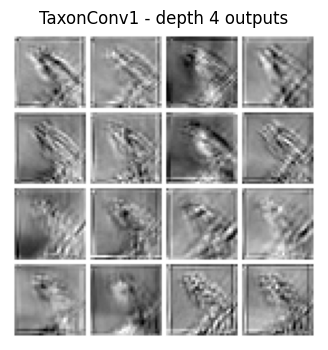

In [63]:
# ─── helper to plot a grid of single‐channel feature‐maps ───────────────────────
def plot_grid(tensor, nrow=8, title=""):
    """
    tensor: (N,1,H,W) or (N,3,H,W)
    """
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, scale_each=True, pad_value=1)
    npimg = grid.permute(1,2,0).cpu().numpy()
    plt.figure(figsize=(4,4))
    plt.title(title)
    plt.axis('off')
    cmap = "viridis"# if npimg.shape[2]==3 else \
    #"gray" if npimg.shape[2]==1 else None
    plt.imshow(npimg, cmap=cmap)
    plt.show()

# ─── visualize one TaxonConv block ─────────────────────────────────────────────
def visualize_taxon_layer(taxon_conv, x, layer_name, temperature):
    """
    taxon_conv: a TaxonConv instance
    x:          input tensor (1, C, H, W)
    """
    prev = None
    for depth, conv in enumerate(taxon_conv.convs, start=1):
        # 1) compute log‐probs at this depth
        # ll    = conv(x) / temperature
        # ll = ll.view(ll.shape[0], -1, 2, ll.shape[2], ll.shape[3])  # shape (batch, channels//2, 2, height, width)
        # logp0 = ll - torch.logsumexp(ll, dim=2, keepdim=True) # shape (batch, channels//2, height, width)
        # logp0 = logp0.view(logp0.shape[0], -1, logp0.shape[3], logp0.shape[4])  # flatten the 2 channels
        # logp0 = ll - torch.logsumexp(ll, dim=1, keepdim=True)
        ll = conv(x)
        ll = F.sigmoid(ll) # apply sigmoid to get probabilities in [0, 1]
        ll = torch.stack([ll, 1 - ll], dim=2).flatten(1, 2)  # shape (batch, channels, height, width)
        logp0 = ll.log() 
        if prev is None:
            out = logp0
        else:
            out = logp0 + prev.repeat_interleave(2, dim=1)
        # print the probabilities for the first pixel in each channel
        print("Probabilities for layer {} at pixel (0,0): {}".format(depth, torch.exp(out[0, :, 0, 0])))

        # # 2) plot its filters
        # w = conv.weight.detach().clone()              # (out_c, in_c, 3,3)
        # w = w.mean(dim=1, keepdim=True)               # → (out_c,1,3,3) for grayscale
        # plot_grid(w, nrow=min(w.shape[0], 8),
        #           title=f"{layer_name} – depth {depth} filters")

        # 3) plot its combined outputs
        fmap = out[0].unsqueeze(1)                    # (out_c,1,H,W)
        n_show = min(fmap.shape[0], 16)
        plot_grid(fmap[:n_show], nrow=4,
                  title=f"{layer_name} - depth {depth} outputs")

        prev = out

# ─── full visualization for ThreeLayerTaxonCNN ────────────────────────────────
def visualize_three_layer_taxoncnn(model, test_loader, device="cuda"):
    model.to(device).eval()
    imgs, _ = next(iter(test_loader))
    x = imgs.to(device)[:1]   # just take a single example
    # also display the original image
    plot_grid(x, nrow=1, title="Original Image")
    

    # Layer 1
    visualize_taxon_layer(
        model.taxon_conv1, x, 
        layer_name="TaxonConv1", 
        temperature=model.temperature
    )
    # x = F.max_pool2d(model.taxon_conv1(x), 2)
    x = model._squash(x)
    # x = F.relu(x)

    # # Layer 2
    # visualize_taxon_layer(
    #     model.taxon_conv2, x,
    #     layer_name="TaxonConv2",
    #     temperature=model.temperature
    # )
    # x = F.max_pool2d(model.taxon_conv2(x), 2)
    # x = model._squash(x)
    
    # x = F.relu(x)

    # # Layer 3
    # visualize_taxon_layer(
    #     model.taxon_conv3, x,
    #     layer_name="TaxonConv3",
    #     temperature=model.temperature
    # )
    # (you can continue if you have more layers…)

visualize_three_layer_taxoncnn(model, train_loader_cifar, device="cuda")

Layer 0 weights shape: (1, 3, 7, 7)


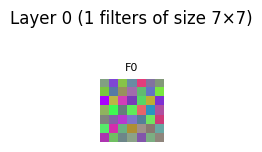

Layer 1 weights shape: (2, 3, 7, 7)


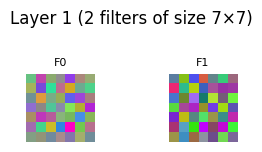

Layer 2 weights shape: (4, 3, 7, 7)


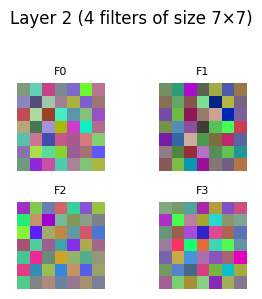

Layer 3 weights shape: (8, 3, 7, 7)


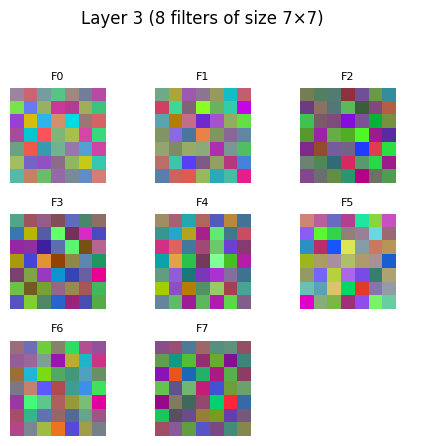

In [64]:
import math
for idx, conv in enumerate(model.taxon_conv1.convs):
    # Extract weight tensor: (out_channels, in_channels, kH, kW)
    weights = conv.weight.detach().cpu().numpy()
    print(f"Layer {idx} weights shape: {weights.shape}")

    # weights = model.conv1.weight.data.cpu().numpy()

    # normalize each filter to [0,1] for display
    min_w = weights.min(axis=(1,2,3), keepdims=True)
    max_w = weights.max(axis=(1,2,3), keepdims=True)
    weights_norm = (weights - min_w) / (max_w - min_w + 1e-5)

    out_channels, in_channels, kH, kW = weights.shape

    # Only visualize the first input channel if in_channels > 1
    kernels = weight[:, 0, :, :]

    # Determine grid size
    n_filters = out_channels
    n_cols = int(math.ceil(math.sqrt(n_filters)))
    n_rows = int(math.ceil(n_filters / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.5))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    elif n_rows == 1 or n_cols == 1:
        axes = np.array(axes).flatten()
    else:
        axes = axes.flatten()

    for i in range(n_filters):
        ax = axes[i]
        # ax.imshow(kernels[i], interpolation='nearest')
        filt = np.transpose(weights_norm[i], (1,2,0))
        ax.imshow(filt)
        ax.set_title(f'F{i}', fontsize=8)
        ax.axis('off')

    # Turn off any extra axes
    for j in range(n_filters, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f'Layer {idx} ({out_channels} filters of size {kH}×{kW})', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Epoch 1/10  Loss: 1.4598
Epoch 2/10  Loss: 1.1295
Epoch 3/10  Loss: 1.0084
Epoch 4/10  Loss: 0.9402
Epoch 5/10  Loss: 0.8862
Epoch 6/10  Loss: 0.8459
Epoch 7/10  Loss: 0.8154
Epoch 8/10  Loss: 0.7886
Epoch 9/10  Loss: 0.7653
Epoch 10/10  Loss: 0.7398


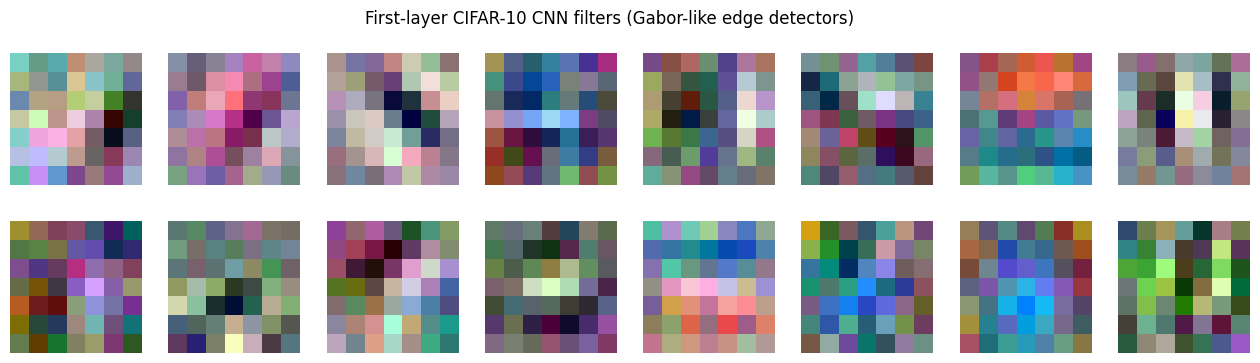

In [ ]:
import torch.optim as optim

# 1) Hyperparameters
batch_size = 128
num_epochs = 10
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 3) Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # first layer: 3→16 channels, kernel 7×7 to make filters more visible
        self.conv1 = nn.Conv2d(3, 16, kernel_size=7, padding=3, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc = nn.Linear(32 * 8 * 8, 10)
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = SimpleCNN().to(device)

# 4) Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 5) Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader_cifar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}  Loss: {running_loss/len(train_loader_cifar):.4f}")

# 6) Visualize the first‐layer filters
#    conv1.weight shape: [16, 3, 7, 7]
weights = model.conv1.weight.data.cpu().numpy()

# normalize each filter to [0,1] for display
min_w = weights.min(axis=(1,2,3), keepdims=True)
max_w = weights.max(axis=(1,2,3), keepdims=True)
weights_norm = (weights - min_w) / (max_w - min_w + 1e-5)

# plot the 16 filters
fig, axes = plt.subplots(2, 8, figsize=(16,4))
for i, ax in enumerate(axes.flatten()):
    # shape (3,7,7) → (7,7,3)
    filt = np.transpose(weights_norm[i], (1,2,0))
    ax.imshow(filt)
    ax.axis('off')

plt.suptitle("First‐layer CIFAR-10 CNN filters (Gabor-like edge detectors)")
plt.show()

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 30, kernel_size=49, stride=1, padding=24)
        self.fc1 = nn.Linear(30 * 224 * 224, 10)
        # self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        # print(f"Shape before flatteningx/: {x.shape}")
        x = x.view(x.size(0), -1)
        # x = F.relu(x)
        x = self.fc1(x)
        return x
# Initialize and train the simple CNN model
simple_model = SimpleCNN()
# train_model(simple_model, train_loader_im1k, train_loader_im1k, epochs=10, lr=0.001)


In [ ]:
# save the model
torch.save(simple_model.state_dict(), 'simple_cnn-im1k.pth')

In [ ]:
# load 
simple_model = SimpleCNN()
simple_model.load_state_dict(torch.load('simple_cnn-im1k.pth'))

<All keys matched successfully>

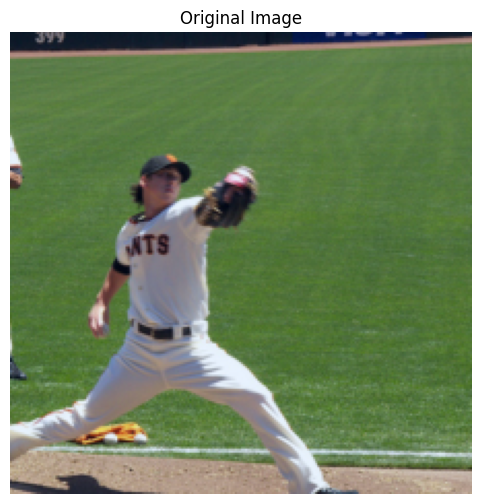

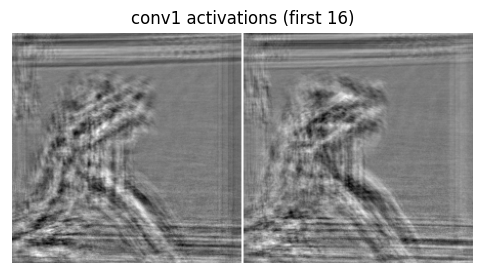

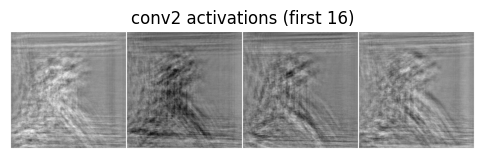

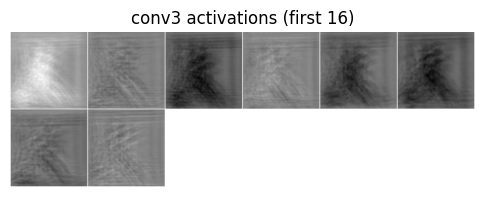

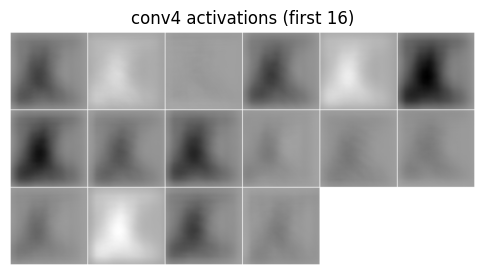

In [ ]:
# ─── your existing plot_grid helper ────────────────────────────────────────────
def plot_grid(tensor, nrow=8, title=""):
    # tensor: (N,1,H,W) or (N,3,H,W)
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, pad_value=1)
    npimg = grid.permute(1,2,0).cpu().numpy()
    plt.figure(figsize=(6,6))
    plt.title(title)
    plt.axis('off')
    plt.imshow(npimg, cmap=("gray" if npimg.shape[2]==1 else None))
    plt.show()

# ─── new: plot activations by direct layer calls ───────────────────────────────
def plot_activations_no_hook(model, x, device="cuda"):
    model = model.to(device).eval()
    x = x.to(device)

    activations = []
    # 1) conv1
    a1 = model.conv1(x)
    # print(f"Shape after conv1: {a1.shape}")
    # a1 = F.relu(a1)
    # print(x[0,0,0,:10])
    activations.append(a1)
    
    # 2) conv2
    a2 = model.conv2(F.relu(a1))
    # # a2 = F.relu(a2)
    activations.append(a2)
    # # 3) conv3
    a3 = model.conv3(F.relu(a2))
    # # a3 = F.relu(a3)
    activations.append(a3)
    # # 4) conv4
    a4 = model.conv4(F.relu(a3))
    # # a4 = F.relu(a4)
    activations.append(a4)

    # plot original
    plot_grid(x, nrow=1, title="Original Image")

    # for each activation, show first 16 maps
    for i, act in enumerate(activations, 1):
        # act: (B, C, H, W) → take batch‐0, expand channel→grid
        maps = act[0].detach().unsqueeze(1)  # (C,1,H,W)
        plot_grid(maps[:], nrow=6, title=f"conv{i} activations (first 16)")

# grab one sample
imgs, _ = next(iter(train_loader_im1k))
x = imgs[:1]             # shape (1,3,224,224)
# raindom imahe
# x = torch.randn(1, 3, 224, 224)  # random image for testing
# plot all intermediate conv activations
plot_activations_no_hook(simple_model, x, device="cuda")

In [ ]:
# grab two *different* images from your (shuffled!) loader
imgs1, _ = next(iter(train_loader_im1k))
imgs2, _ = next(iter(train_loader_im1k))
x1 = imgs1[:1].to('cuda')
x2 = imgs2[:1].to('cuda')

# run conv1 directly
out1 = simple_model.conv1(x1)
out2 = simple_model.conv1(x2)

# how different are they?
print("Sum of absolute differences:", (out1 - out2).abs().sum().item())

# inspect your conv1 weights
w = simple_model.conv1.weight.data
print(f"conv1 weight — mean: {w.mean().item():.3f}, std: {w.std().item():.3f}, min: {w.min().item():.3f}, max: {w.max().item():.3f}")

Sum of absolute differences: 0.0
conv1 weight — mean: 0.000, std: 0.007, min: -0.013, max: 0.014


In [ ]:
random_x = torch.randn(1, 1, 28, 28)  # random input tensor simulating a single MNIST image

root_ll = root_conv(random_x) # shape (1, 1, 28, 28)
root_prob = torch.exp(root_ll) # shape (1, 1, 28, 28)
root_prob = torch.stack([root_prob, 1 - root_prob], dim=2).view(1, 2, 28, 28) # shape (1, 2, 28, 28)
root_out = torch.log(root_prob) # shape (1, 2, 28, 28)

layer1_ll = layer1_conv(random_x) # shape (1, 2, 28, 28)
layer1_prob = torch.exp(layer1_ll) # shape (1, 2, 28, 28)
layer1_prob = torch.stack([layer1_prob, 1 - layer1_prob], dim=2).view(1, 4, 28, 28) # shape (1, 4, 28, 28)
layer1_out = torch.log(layer1_prob) + root_out.repeat_interleave(2, dim=1)

layer2_ll = layer2_conv(random_x) # shape (1, 4, 28, 28)
layer2_prob = torch.exp(layer2_ll) # shape (1, 4, 28, 28)
layer2_prob = torch.stack([layer2_prob, 1 - layer2_prob], dim=2).view(1, 8, 28, 28) # shape (1, 8, 28, 28)
layer2_out = torch.log(layer2_prob) + layer1_out.repeat_interleave(2, dim=1) # shape (1, 8, 28, 28)

# layer3_ll = layer3_conv(random_x) # shape (1, 8, 28, 28)
# layer3_prob = torch.exp(layer3_ll) # shape (1, 8, 28, 28)
# layer3_prob = torch.stack([layer3_prob, 1 - layer3_prob], dim=2).view(1, 16, 28, 28) # shape (1, 16, 28, 28)
# layer3_out = torch.log(layer3_prob) + layer2_out.repeat_interleave(2, dim=1) # shape (1, 16, 28, 28)

out = torch.cat([root_out, layer1_out, layer2_out], dim=1)  # shape (1, 30, 28, 28)
print("Output shape:", out.shape)

Output shape: torch.Size([1, 14, 28, 28])


In [ ]:
a = torch.tensor([0.9, 0.3, 0.1])
a.view(3, 1).repeat(1, 2).view(-1)

tensor([0.9000, 0.9000, 0.3000, 0.3000, 0.1000, 0.1000])

In [ ]:
a = torch.tensor([[1]])
b = torch.tensor([[3]])
print(a.shape, b.shape)
torch.stack([a, b], dim=2).view(1,-1)

torch.Size([1, 1]) torch.Size([1, 1])


tensor([[1, 3]])